# PyMC3 Example

INSERT INTRO

## Load libraries

In [308]:
%pylab inline
import pymc3 as pm
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import theano.tensor as T
import theano
plt.style.use(['seaborn-talk'])
plt.rcParams["figure.figsize"] = (10,8)
print(pm.__version__)
print(theano.__version__)

Populating the interactive namespace from numpy and matplotlib
3.5
1.0.2


//anaconda/envs/py36/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['trace']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## define colors

In [2]:
c_light ="#DCBCBC"
c_light_highlight ="#C79999"
c_mid ="#B97C7C"
c_mid_highlight ="#A25050"
c_dark ="#8F2727"
c_dark_highlight ="#7C0000"

# Section 3.1

Build a model that generates Poisson counts

## Build a generative model

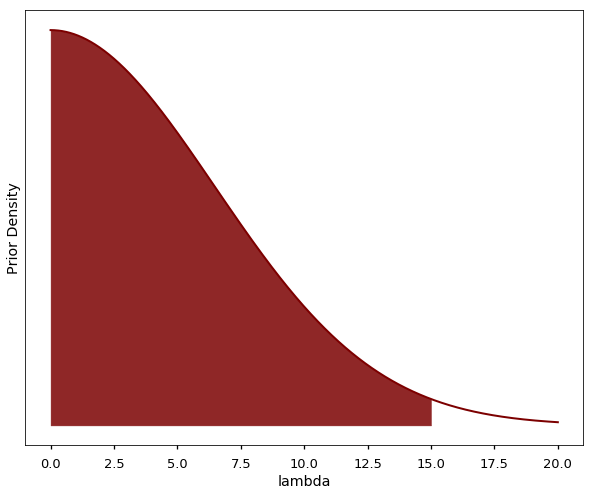

In [3]:
lbda  = np.linspace(0, 20, num=int(20/0.001))

plt.plot(lbda, stats.norm(loc=0,scale=6.44787).pdf(lbda), c=c_dark_highlight, lw=2)
plt.xlabel("lambda"); plt.ylabel("Prior Density"); plt.yticks([]);


lbda99 = np.linspace(0, 15, num=int(15/0.001))



plt.fill_between(lbda99,0.,y2=stats.norm(loc=0,scale=6.44787).pdf(lbda99),color=c_dark)

In [258]:
#WORKING

model = pm.Model()
N = 1000
R = 500
with model:
    lbda = pm.HalfNormal("lbda",sd=6.44787)
    
    y = pm.Poisson("y",mu=lbda,shape=(N,),observed=None)
    

In [259]:
with generative_model:
    trace = pm.sample_prior_predictive(samples=R)

In [261]:
simu_lbdas = trace['lbda']
simu_ys = trace['y']

## Plot prior predictive distribution

In [301]:
x_max = 30
bins = np.arange(0,x_max)
bin_interp = np.linspace(0,x_max-1,num=(x_max-1)*10)
hists = np.apply_along_axis(lambda a: np.histogram(a, bins=bins)[0], 1, simu_ys)

prctiles = np.percentile(hists,np.linspace(10,90,num=9),axis=0)
prctiles_interp = np.repeat(prctiles, 10,axis=1)

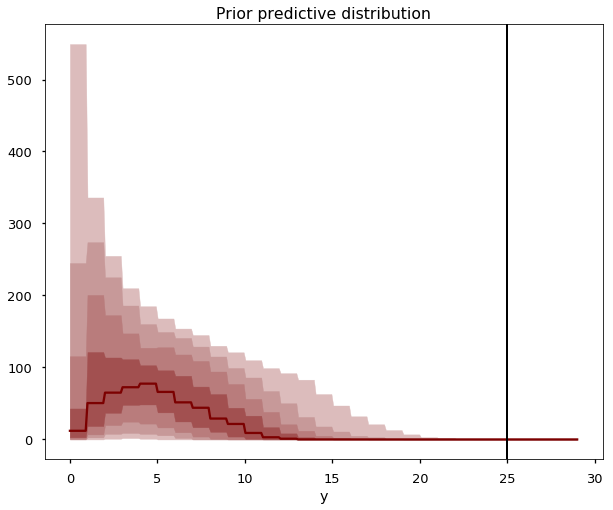

In [307]:
for i,color in enumerate([c_light,c_light_highlight,c_mid,c_mid_highlight]):
    plt.fill_between(bin_interp,prctiles_interp[i,:],prctiles_interp[-1-i,:],alpha=1.0,color=color);


plt.plot(bin_interp,prctiles_interp[4,:],color=c_dark_highlight);
plt.axvline(x=25,ls='-',lw=2,color='k');
plt.xlabel('y');
plt.title('Prior predictive distribution');

## Fit to simulated data

# Section 3.2

Matt to do

# Section 3.3

Mike to do

# Section 3.4

Matt to do